In [2]:
import numpy as np
from scipy.optimize import fmin
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


### Functions

In [3]:
#adding these to run the bbsw functions
wave = np.arange(400, 701, 1)
chl = 0.228
T = 27.6949
S = 35.6639

In [4]:
def RInw(lambda_nm, Tc, S):
    
    # % refractive index of air is from Ciddor (1996,Applied Optics)
    n_air = 1.0 + (5792105.0 / (238.0185 - 1 / (lambda_nm / 1e3) ** 2) + 167917.0 / (57.362 - 1 / (lambda_nm / 1e3) ** 2)) / 1e8

    # refractive index of seawater is from Quan and Fry (1994, Applied Optics)
    n0 = 1.31405
    n1 = 1.779e-4
    n2 = -1.05e-6
    n3 = 1.6e-8
    n4 = -2.02e-6
    n5 = 15.868
    n6 = 0.01155
    n7 = -0.00423
    n8 = -4382
    n9 = 1.1455e6
    
    nsw = n0 + (n1 + n2 * Tc + n3 * Tc ** 2) * S + n4 * Tc ** 2 + (n5 + n6 * S + n7 * Tc) / lambda_nm + n8 / lambda_nm ** 2 + n9 / lambda_nm ** 3
    nsw *= n_air
    dnswds = (n1 + n2 * Tc + n3 * Tc ** 2 + n6 / lambda_nm) * n_air

    return nsw, dnswds


In [5]:
nsw, dnds = RInw(wave, T, S)
print(nsw)
print(dnds)

[1.34954518 1.34944717 1.34934997 1.34925358 1.34915797 1.34906314
 1.34896909 1.3488758  1.34878326 1.34869147 1.34860041 1.34851007
 1.34842046 1.34833155 1.34824334 1.34815582 1.34806899 1.34798283
 1.34789734 1.34781251 1.34772833 1.34764479 1.34756189 1.34747962
 1.34739797 1.34731693 1.3472365  1.34715667 1.34707744 1.34699879
 1.34692072 1.34684322 1.3467663  1.34668993 1.34661411 1.34653885
 1.34646412 1.34638993 1.34631627 1.34624313 1.34617051 1.34609841
 1.3460268  1.3459557  1.3458851  1.34581499 1.34574536 1.3456762
 1.34560753 1.34553932 1.34547158 1.34540429 1.34533746 1.34527108
 1.34520514 1.34513965 1.34507458 1.34500995 1.34494575 1.34488196
 1.3448186  1.34475564 1.3446931  1.34463095 1.34456921 1.34450787
 1.34444691 1.34438635 1.34432616 1.34426636 1.34420694 1.34414788
 1.3440892  1.34403088 1.34397292 1.34391532 1.34385807 1.34380117
 1.34374462 1.34368842 1.34363255 1.34357702 1.34352182 1.34346696
 1.34341242 1.3433582  1.34330431 1.34325073 1.34319747 1.34314

In [6]:
def BetaT(Tc, S):
    # pure water secant bulk Millero (1980, Deep-sea Research)
    kw = 19652.21 + 148.4206*Tc - 2.327105*Tc**2 + 1.360477e-2*Tc**3 - 5.155288e-5*Tc**4
    Btw_cal = 1.0 / kw

    # isothermal compressibility from Kell sound measurement in pure water
    # Btw = (50.88630 + 0.717582*Tc + 0.7819867e-3*Tc**2 + 31.62214e-6*Tc**3 - 0.1323594e-6*Tc**4 + 0.634575e-9*Tc**5) / (1 + 21.65928e-3*Tc) * 1e-6

    # seawater secant bulk
    a0 = 54.6746 - 0.603459*Tc + 1.09987e-2*Tc**2 - 6.167e-5*Tc**3
    b0 = 7.944e-2 + 1.6483e-2*Tc - 5.3009e-4*Tc**2

    Ks = kw + a0*S + b0*S**1.5

    # calculate seawater isothermal compressibility from the secant bulk
    IsoComp = 1.0 / Ks * 1e-5  # unit is pa
    return IsoComp


In [7]:
BetaT(T, S)

4.1890036793374115e-10

In [29]:
def rhou_sw(Tc, S):
    # density of water and seawater, unit is Kg/m^3, from UNESCO,38,1981
    a0 = 8.24493e-1
    a1 = -4.0899e-3
    a2 = 7.6438e-5
    a3 = -8.2467e-7
    a4 = 5.3875e-9
    a5 = -5.72466e-3
    a6 = 1.0227e-4
    a7 = -1.6546e-6
    a8 = 4.8314e-4
    b0 = 999.842594
    b1 = 6.793952e-2
    b2 = -9.09529e-3
    b3 = 1.001685e-4
    b4 = -1.120083e-6
    b5 = 6.536332e-9
     
    # density for pure water 
    density_w = b0 + b1*Tc + b2*Tc**2 + b3*Tc**3 + b4*Tc**4 + b5*Tc**5
    # density for pure seawater
    density_sw = density_w + ((a0 + a1*Tc + a2*Tc**2 + a3*Tc**3 + a4*Tc**4)*S + (a5 + a6*Tc + a7*Tc**2)*S**1.5 + a8*S**2)
    
    return density_sw


In [30]:
rhou_sw(T, S)

1022.9957884910589

In [10]:
def dlnasw_ds(Tc, S):
    # water activity data of seawater is from Millero and Leung (1976,American
    # Journal of Science,276,1035-1077). Table 19 was reproduced using
    # Eqs.(14,22,23,88,107) then were fitted to polynomial equation.
    # dlnawds is the partial derivative of the natural logarithm of water activity
    # with respect to salinity
    
    dlnawds = (-5.58651e-4 + 2.40452e-7*Tc - 3.12165e-9*Tc**2 + 2.40808e-11*Tc**3) + \
              1.5 * (1.79613e-5 - 9.9422e-8*Tc + 2.08919e-9*Tc**2 - 1.39872e-11*Tc**3) * S**0.5 + \
              2 * (-2.31065e-6 - 1.37674e-9*Tc - 1.93316e-11*Tc**2) * S
    
    return dlnawds

In [11]:
dlnasw_ds(T, S)

-0.0005745426089058156

In [12]:
def PMH(n_wat):
    n_wat2 = n_wat ** 2
    n_density_derivative = (n_wat2 - 1) * (1 + 2/3 * (n_wat2 + 2) * (n_wat/3 - 1/(3*n_wat)) ** 2)
    return n_density_derivative

In [13]:
PMH(nsw)

array([0.90736378, 0.90702263, 0.90668437, 0.90634897, 0.90601638,
       0.90568657, 0.90535951, 0.90503516, 0.90471349, 0.90439446,
       0.90407804, 0.90376421, 0.90345292, 0.90314415, 0.90283786,
       0.90253403, 0.90223263, 0.90193362, 0.90163698, 0.90134267,
       0.90105068, 0.90076096, 0.90047351, 0.90018828, 0.89990525,
       0.8996244 , 0.8993457 , 0.89906912, 0.89879464, 0.89852224,
       0.89825189, 0.89798356, 0.89771724, 0.8974529 , 0.89719051,
       0.89693007, 0.89667153, 0.89641489, 0.89616011, 0.89590719,
       0.89565609, 0.8954068 , 0.89515929, 0.89491355, 0.89466956,
       0.8944273 , 0.89418674, 0.89394788, 0.89371068, 0.89347514,
       0.89324123, 0.89300894, 0.89277824, 0.89254913, 0.89232158,
       0.89209558, 0.89187111, 0.89164816, 0.8914267 , 0.89120673,
       0.89098822, 0.89077116, 0.89055554, 0.89034134, 0.89012854,
       0.88991714, 0.88970711, 0.88949844, 0.88929112, 0.88908513,
       0.88888047, 0.88867711, 0.88847504, 0.88827426, 0.88807

In [44]:
# Xiaodong Zhang, Lianbo Hu, and Ming-Xia He (2009), Scatteirng by pure
# seawater: Effect of salinity, Optics Express, Vol. 17, No. 7, 5698-5710 

# lambda (nm): wavelength
# Tc: temperauter in degree Celsius, must be a scalar
# S: salinity, must be scalar
# delta: depolarization ratio, if not provided, default = 0.039 will be used.
# betasw: volume scattering at angles defined by theta. Its size is [x y],
# where x is the number of angles (x = length(theta)) and y is the number
# of wavelengths in lambda (y = length(lambda))
# beta90sw: volume scattering at 90 degree. Its size is [1 y]
# bw: total scattering coefficient. Its size is [1 y]
# for backscattering coefficients, divide total scattering by 2

# Xiaodong Zhang, March 10, 2009

def betasw_ZHH2009(wave, Tc, theta, S, delta=0.039):
    # Constants
    Na = 6.0221417930e23  # Avogadro's constant
    Kbz = 1.3806503e-23  # Boltzmann constant
    Tk = Tc + 273.15  # Absolute temperature
    M0 = 18e-3  # Molecular weight of water in kg/mol

    if np.isscalar(Tc) and np.isscalar(S):
        Tc = np.array([Tc])
        S = np.array([S])
    else:
        raise ValueError("Both Tc and S must be scalar variables.")

    # Convert input to numpy arrays
    lambda_nm = np.array(wave) #a row variable
    rad = np.deg2rad(theta) #angle in radian as a column variable

    # nsw: absolute refractive index of seawater
    # dnds: partial derivative of seawater refractive index w.r.t. salinity
    nsw, dnds = RInw(lambda_nm, Tc, S)

    # isothermal compressibility is from Lepple & Millero (1971,Deep Sea-Research), pages 10-11
    #The error ~ +/-0.004e-6 bar^-1
    IsoComp = BetaT(Tc, S)
    
    # density of water and seawater,unit is Kg/m^3, from UNESCO,38,1981
    density_sw = rhou_sw(Tc, S)
    
    # water activity data of seawater is from Millero and Leung (1976, American
    # Journal of Science,276,1035-1077). Table 19 was reproduced using Eq.(14,22,23,88,107)
    # then were fitted to polynominal equation.
    # dlnawds is partial derivative of natural logarithm of water activity w.r.t.salinity
    dlnawds = dlnasw_ds(Tc, S)
    
    # density derivative of refractive index from PMH model
    DFRI = PMH(nsw)  # PMH model
    
    # volume scattering at 90 degree due to the density fluctuation
    beta_df = np.pi * np.pi / 2 * ((lambda_nm * 1e-9) ** (-4)) * Kbz * Tk * IsoComp * DFRI ** 2 * (6 + 6 * delta) / (6 - 7 * delta)
    
    # volume scattering at 90 degree due to the concentration fluctuation
    flu_con = S * M0 * dnds ** 2 / density_sw / (-dlnawds) / Na
    beta_cf = 2 * np.pi * np.pi * ((lambda_nm * 1e-9) ** (-4)) * nsw ** 2 * (flu_con) * (6 + 6 * delta) / (6 - 7 * delta)
   
    # total volume scattering at 90 degree
    beta90sw = beta_df + beta_cf
    bsw = 8 * np.pi / 3 * beta90sw * (2 + delta) / (1 + delta)
    betasw = beta90sw[:, np.newaxis] * (1 + ((np.cos(rad)) ** 2) * (1 - delta) / (1 + delta))

    return betasw, beta90sw, bsw


[0.00658767 0.00651706 0.00644739 0.00637867 0.00631087 0.00624398
 0.00617798 0.00611286 0.0060486  0.0059852  0.00592263 0.00586089
 0.00579996 0.00573982 0.00568048 0.0056219  0.00556408 0.00550702
 0.00545069 0.00539508 0.00534019 0.00528601 0.00523251 0.0051797
 0.00512755 0.00507607 0.00502524 0.00497505 0.00492548 0.00487654
 0.00482821 0.00478049 0.00473335 0.00468681 0.00464083 0.00459543
 0.00455058 0.00450628 0.00446253 0.00441931 0.00437661 0.00433443
 0.00429277 0.00425161 0.00421094 0.00417076 0.00413106 0.00409184
 0.00405309 0.0040148  0.00397696 0.00393957 0.00390262 0.00386611
 0.00383002 0.00379436 0.00375911 0.00372428 0.00368985 0.00365582
 0.00362219 0.00358894 0.00355608 0.00352359 0.00349148 0.00345973
 0.00342835 0.00339732 0.00336665 0.00333632 0.00330634 0.00327669
 0.00324738 0.0032184  0.00318974 0.0031614  0.00313337 0.00310566
 0.00307826 0.00305116 0.00302436 0.00299785 0.00297163 0.00294571
 0.00292006 0.0028947  0.00286961 0.0028448  0.00282025 0.00279

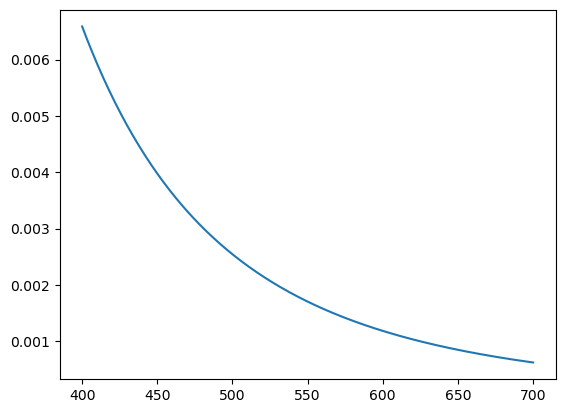

In [59]:
bsw = betasw_ZHH2009(wave, T, [], S)
print(bsw[2])
plt.plot(wave, bsw[2])

In [47]:
def gsm_cost(IOPs, rrs, aw, bbw, bbpstar, aphstar, admstar):
    g = np.array([0.0949, 0.0794])  # orig., constants in eq 2. Gordon et al., 1998
    a = aw + IOPs[0] * aphstar + IOPs[1] * admstar
    bb = bbw + IOPs[2] * bbpstar
    x = bb / (a + bb)
    rrspred = (g[0] + g[1] * x) * x
    cost = np.sum((rrs - rrspred) ** 2)
    return cost

In [48]:
def gsm_invert(rrs, aw, bbw, bbpstar, aphstar, admstar):
    options = {'xtol': 1e-9, 'ftol': 1e-9, 'maxfev': 2000, 'maxiter': 2000}
    IOPs = np.full((rrs.shape[0], 3), np.nan)
    
    IOPsinit = np.array([0.02, 0.01, 0.0029]) #NOTE THAT THE CHL RETRIEVALS ARE ESPECIALLY SENSITIVE TO INITIAL GUESS!

    #for i in range(rrs.shape[0]):
    rrs_obs = rrs.values
    minimum = fmin(gsm_cost, IOPsinit, args=(rrs_obs, aw, bbw, bbpstar, aphstar, admstar), xtol=1e-9, ftol=1e-9, maxfun=2000, maxiter=2000, full_output=True, retall=True) #options=options)
    #print(minimum)

    #if minimum[4]==1:  #if converged then use value as IOP and inital guess
    IOPs = minimum[0]
    return IOPs

'''
for i in range(rrs.shape[0]):
    print(i)
    rrs_obs = rrs.values[i]
    print(rrs_obs)
    result = minimize(gsm_cost, IOPsinit, args=(rrs_obs, aw, bbw, bbpstar, aphstar, admstar), method='Nelder-Mead',
                     options=options)

    print(result)
    print(result.x)
    #if result.success==True:
        #print(result) 
    IOPs[i, :] = result.x
''' 
    

"\nfor i in range(rrs.shape[0]):\n    print(i)\n    rrs_obs = rrs.values[i]\n    print(rrs_obs)\n    result = minimize(gsm_cost, IOPsinit, args=(rrs_obs, aw, bbw, bbpstar, aphstar, admstar), method='Nelder-Mead',\n                     options=options)\n\n    print(result)\n    print(result.x)\n    #if result.success==True:\n        #print(result) \n    IOPs[i, :] = result.x\n"

### Input data

In [49]:
asw_data = pd.read_csv('/Users/awindled/Documents/Kramer_code/Rrs_pigments/aw_mcf16_350_700_1nm.csv')
asw_data = asw_data.rename(columns={"Lambda": "wv"}).set_index('wv')
coeff_data = pd.read_csv('/Users/awindled/Documents/Kramer_code/Rrs_pigments/aph_A_B_Coeffs_Sasha_RSE_paper.csv').replace(',','', regex=True).astype(float)
coeff_data = coeff_data.rename(columns={"wavelength,": "wv", "A,": "A"}).set_index('wv')

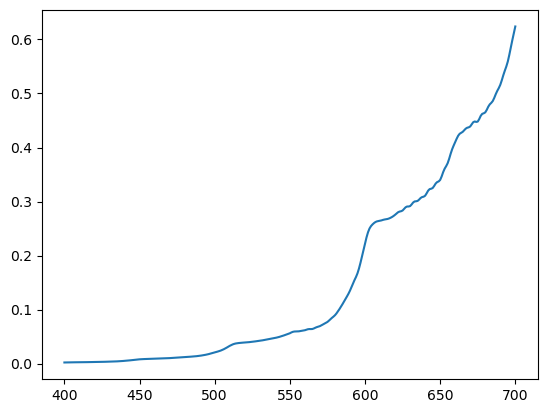

In [50]:
asw = asw_data.iloc[50:].values # subset for your wavelengths (400-700)
plt.plot(wave, asw, label='asw/10')

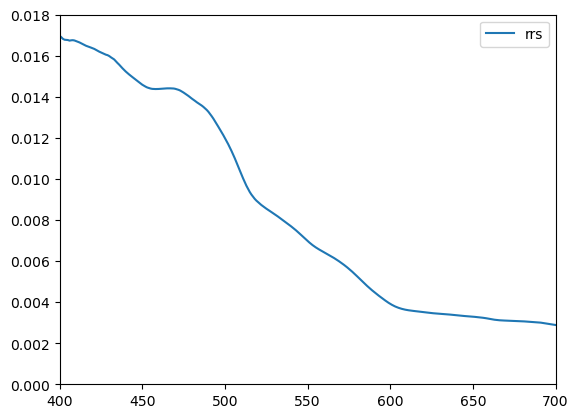

In [51]:
dat = pd.read_csv('/Users/awindled/Documents/Shearwater_Cruise/trios_data/20210827_transect3_mean_std.csv', index_col=0)

#smooth data
dat = dat.rolling(5).mean()
#print(dat)

Rrs = dat['Offshore mean'].loc[400:700,]
wave = np.arange(400, 701, 1)
#plt.plot(wave, Rrs, label='Rrs')

rrs = Rrs/(0.52 + 1.7*Rrs)

plt.plot(wave, rrs, label='rrs')
plt.axis([400, 700, 0, 0.018]) #changes the plotting axes

plt.legend()

chl = 0.228
T = 27.6949
S = 35.6639


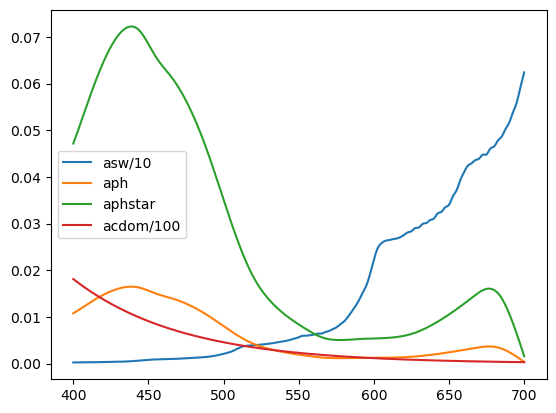

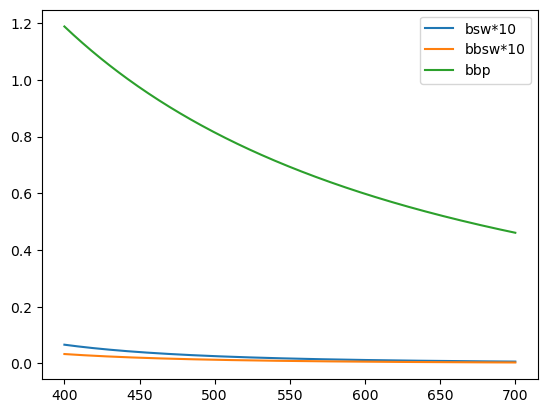

In [52]:
#Script to run hyperspectral reflectance model from Kramer et al. (2022)
#Runs with: betasw_ZHH2009.m, gsm_invert.m, gsm_cost.m
#Inputs: measured Rrs, chlorophyll, temp, sal, asw, A&B coeffs for aph

#Rrs is a function of IOPs, specifically absorption and backscattering. 
#Here, you will build the absorption and backscattering terms from their 
#component parts, and then match the modeled spectra to the measured 
#spectra to optimize the model fit.

#The model uses reflectance = f(IOPs) from Gordon et al. (1988) which uses
#below the surface reflectance (rrs = Lu(0-)/Ed(0-)). If you are using 
#above surface reflectance (Rrs = Lu(0+)/Ed(0+)), you will need to convert
#your reflectances before running this model, using the equation below from
#Lee et al. (2002):
#rrs = Rrs/(0.52 + 1.7*Rrs);

# Define wavelengths
wave = np.arange(400, 701, 1)

# First, define total absorption as a sum of seawater absorption (asw),
# phytoplankton absorption (aph) and CDOM plus other detrital matter (acdm)
#a_tot = asw + aphstar + acdm
asw = asw_data.iloc[50:].values # subset for your wavelengths (400-700)
plt.plot(wave, asw/10, label='asw/10')

# aphstar = aph/chl --> aph = import A & B coefficients from aph_A_B_Coeffs_Sasha_RSE_paper.txt
A = coeff_data.iloc[50:, 0].values #subsets to 400-700 wl (gets rid of first 50)
B = coeff_data.iloc[50:, 1].values
aph = A * chl**B
aphstar = aph / chl
plt.plot(wave, aph, label='aph')
plt.plot(wave, aphstar, label='aphstar')

# Calculate acdm
acdm_s = -0.01447 + 0.00033 * Rrs.loc[490] / Rrs.loc[555]
acdm = np.exp(acdm_s * (wave - 443))
plt.plot(wave, acdm/100, label='acdom/100')
plt.legend()


#Then, define backscattering as a sum of seawater backscattering (bbsw) and backscattering by particles (bbp)
#bb_tot = bbsw + bbp
#bsw comes from Zhang et al. (2009):
bsw = betasw_ZHH2009(wave,T,[],S)
bbsw = 0.5*bsw[2]
plt.figure(2)
plt.plot(wave, bsw[2]*10, label='bsw*10')
plt.plot(wave, bbsw*10, label='bbsw*10')

# bbp slope is a function of rrs (just below surface)
bbp_s = 2.0 * (1.0 - 1.2 * np.exp(-0.9 * rrs.loc[440] / rrs.loc[555]))
bbp = (443 / wave) ** bbp_s
plt.plot(wave, bbp, label='bbp')
plt.legend()


In [53]:
#Put IOPs together
IOPs = gsm_invert(rrs, asw, bbsw, bbp, aphstar, acdm) 
#outputs = chl, acdm443, bbp443

Optimization terminated successfully.
         Current function value: 5.214355
         Iterations: 183
         Function evaluations: 343


In [54]:
IOPs #inital guess: ([0.02, 0.01, 0.0029])

array([ 0.01354559,  0.00610015, -0.00029183])

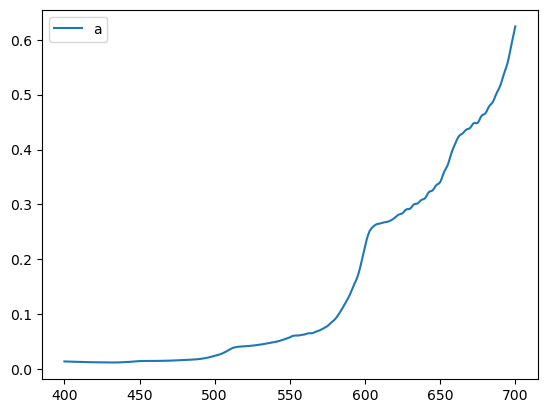

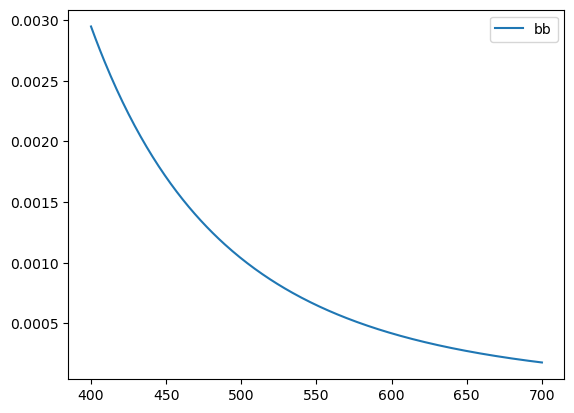

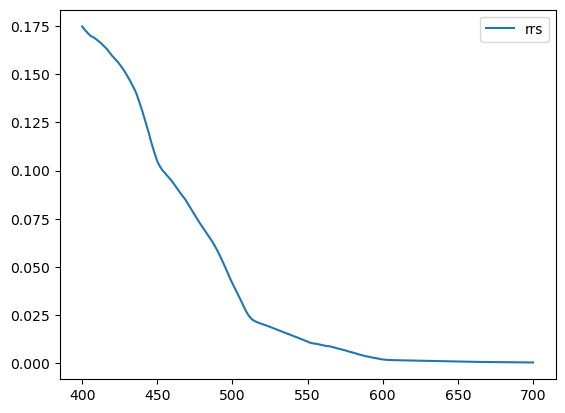

In [55]:
#Reconstruct Rrs
a = asw[:,0] + IOPs[0] * aphstar + IOPs[1] * acdm
plt.plot(wave, a, label='a')
plt.legend()

bb = bbsw + IOPs[2] * bbp
plt.figure(2)
plt.plot(wave, bb, label='bb')
plt.legend()

rrsP = bb / (a + bb)
plt.figure(3)
plt.plot(wave, rrsP, label='rrs')
plt.legend()

g = np.array([0.0949, 0.0794])  # Coefficients from Gordon et al. (1988)
modRrs = g[0] * rrsP + g[1] * rrsP*rrsP

# Residual between measured and modeled (to use for Kramer_hyperRrs.m)
rrsD = Rrs - modRrs

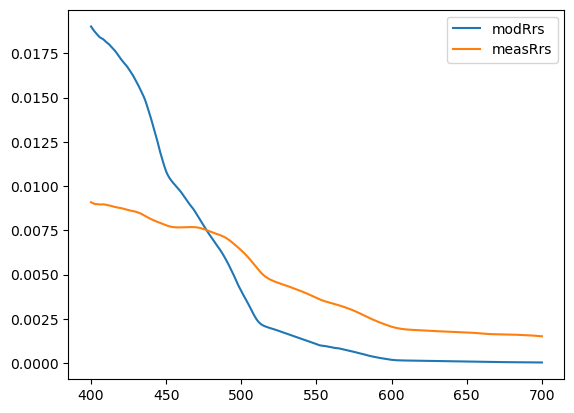

In [56]:
plt.plot(wave, modRrs, label='modRrs')
plt.plot(wave, Rrs, label='measRrs')
plt.legend()

(-0.02, 0.01)

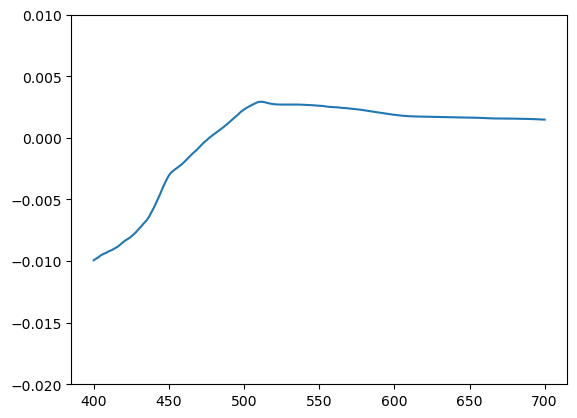

In [57]:
plt.plot(wave, rrsD)
plt.ylim(-0.02, 0.01)
#plt.ylim(-0.0004,0.0004)

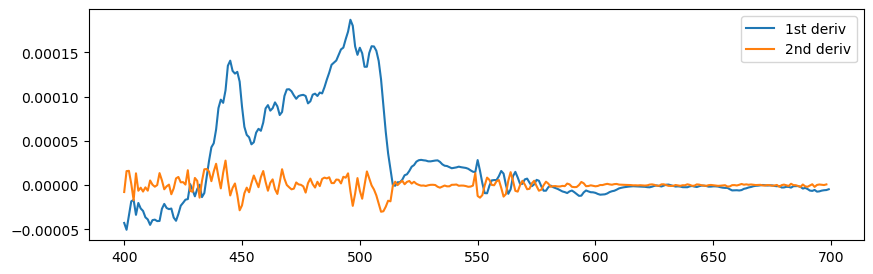

In [27]:
# Calculate the first derivative (diffD)
RrsD = np.diff(rrsD, axis=0)
# Calculate the second derivative (diffD2) of the first derivative
RrsD2 = np.diff(RrsD, axis=0)

plt.figure(figsize=(10,3))
plt.plot(wave[:-1], RrsD, label='1st deriv')
plt.plot(wave[:-2], RrsD2, label='2nd deriv')
plt.legend()